# **Hotspots finder from https://github.com/friburgo-moc/FidelityFinder**

In [ ]:
#@markdown # Upload your CSV files
#@markdown The input must be csv files with the following format: POS, REF, ALT, AO, CIGAR, TYPE, AO_rate\
#@markdown CSV files with this format can be obtained using the vcf_analyzer
from google.colab import files
uploaded = files.upload()
csv_files = uploaded.keys()

Saving undefined.csv to undefined (2).csv
Saving HN00191375_BH10ala11.csv to HN00191375_BH10ala11 (6).csv
Saving HN00196930_BH10Mg05.csv to HN00196930_BH10Mg05 (6).csv
Saving HN00195143_BH10ala9.csv to HN00195143_BH10ala9 (6).csv
Saving HN00196930_BH10Mg3.csv to HN00196930_BH10Mg3 (6).csv


In [ ]:
#@markdown # Input parameters
#@markdown
output_prefix = "undefined" #@param {type:"string"}
#@markdown - Graphs sizes:
graphs_x_axis_size = 50 # @param {type:"integer"}
graphs_y_axis_size = 8 # @param {type:"integer"}
#@markdown - Select to use log-scale in the y-axis of the graphs
graphs_log_scale = True #@param {type:"boolean"}
#@markdown - Select to show each position tick in the x-axis of the graphs
graphs_detailed = False #@param {type:"boolean"}
#@markdown - Select if you want to define a minimum and a maixum value for the x-axis in the graphs and then write the values
graphs_fixed_range = True #@param {type:"boolean"}
graphs_x_min= 0 # @param {type:"integer"}
graphs_x_max = 850 # @param {type:"integer"}

	Step 1 => Creating merged dataframe
	Step 1 done

	Step 2 => Extracting data and creating graphs and tables
	Step 2 done

	JOB DONE!


<Figure size 640x480 with 0 Axes>

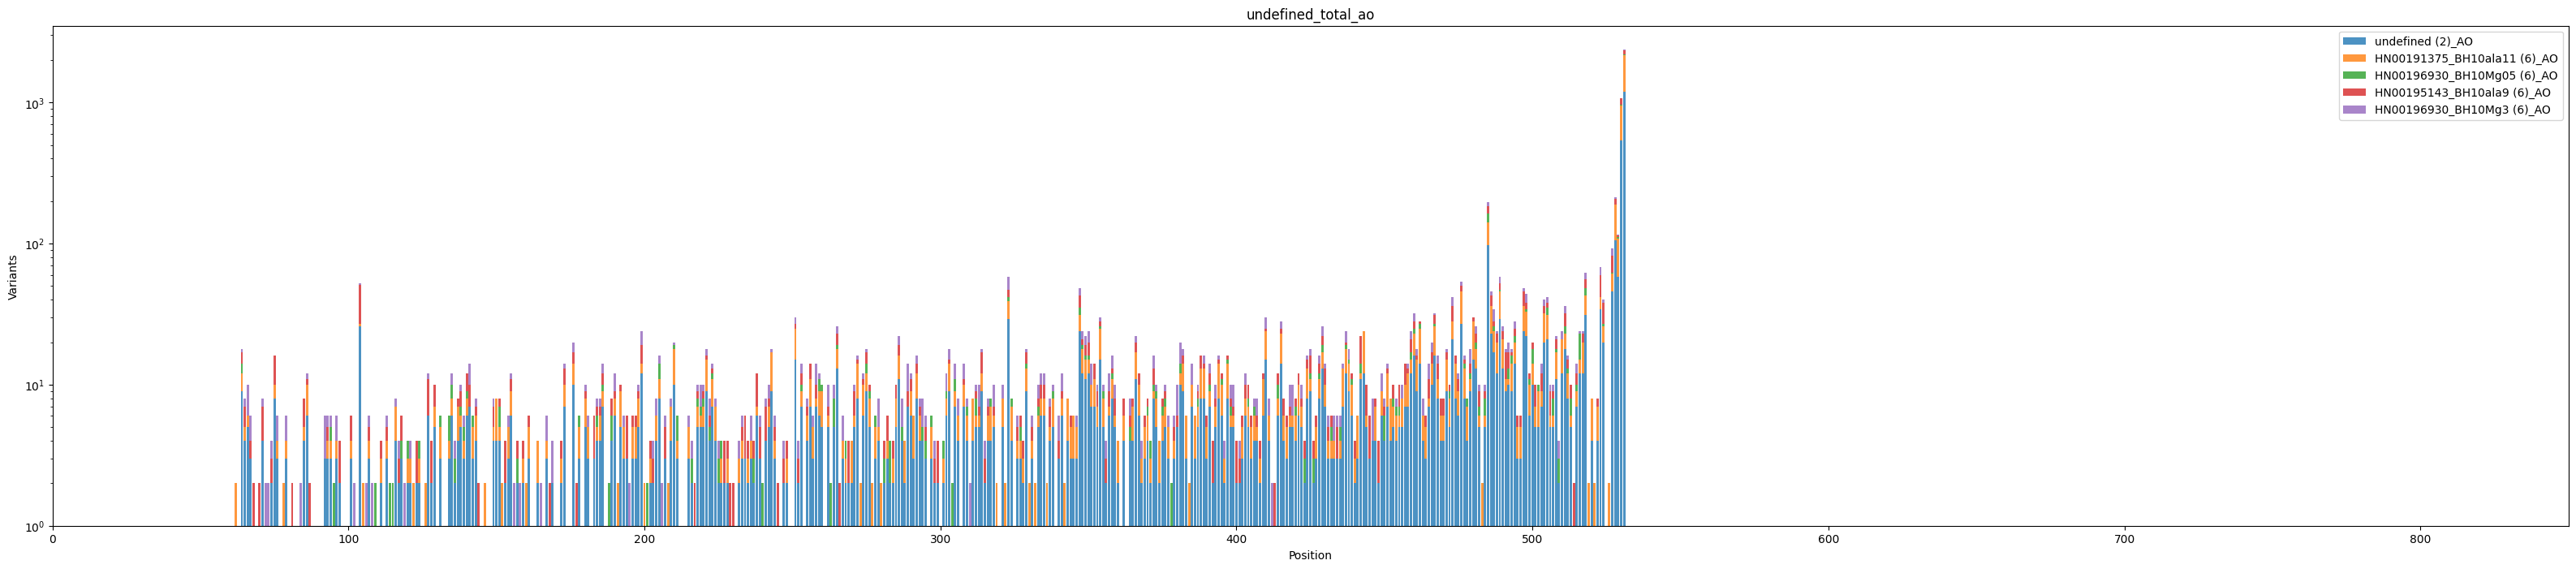

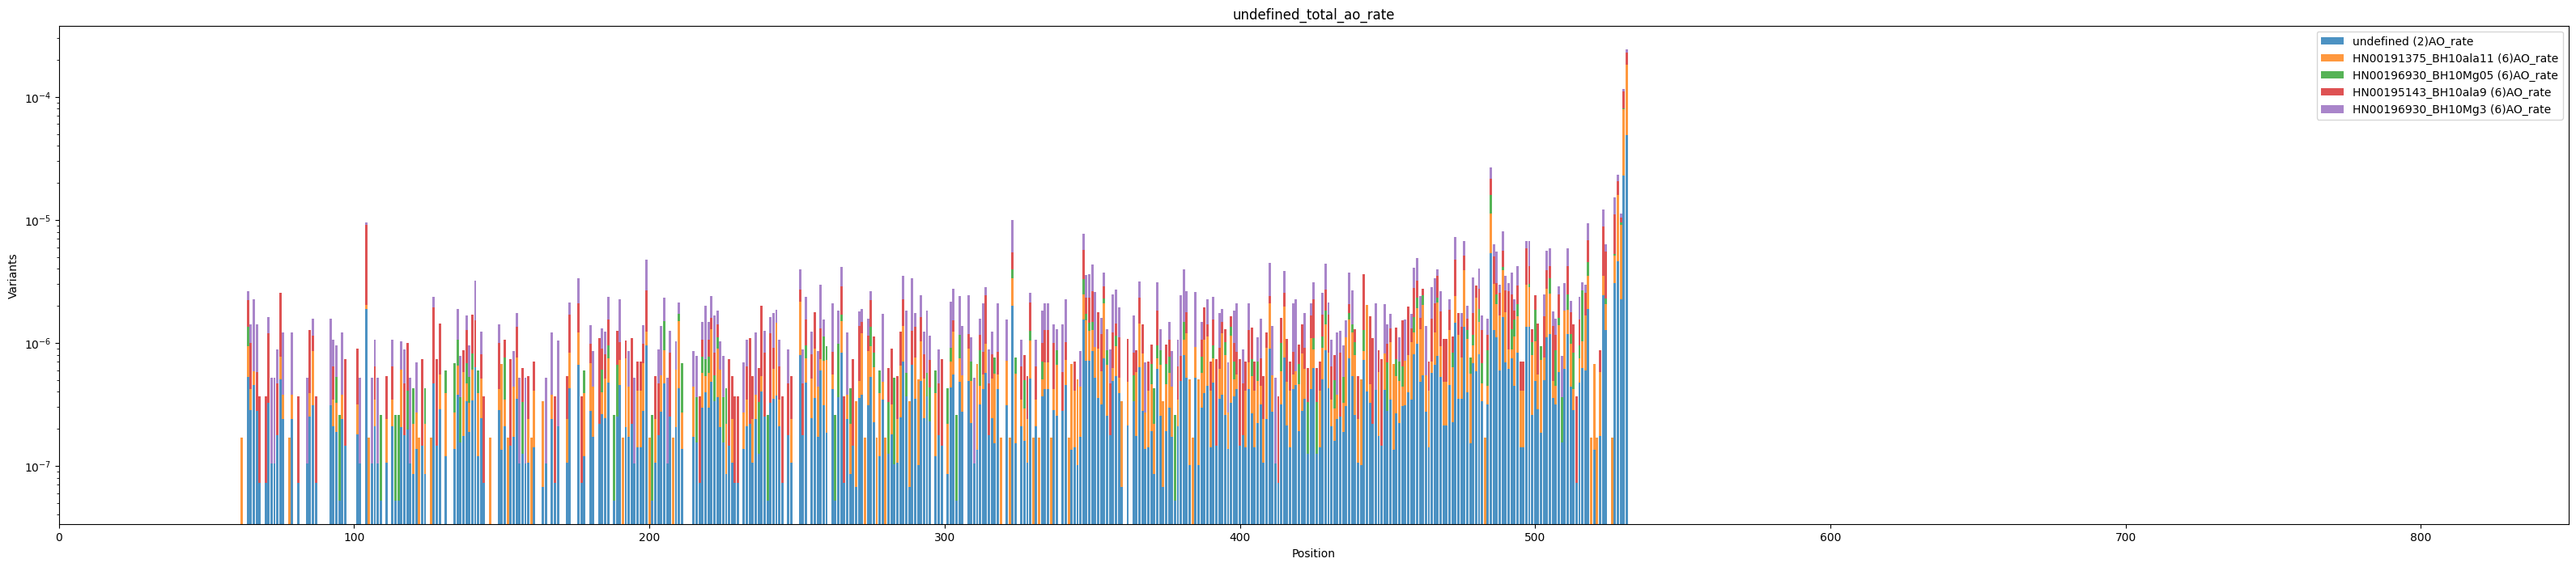

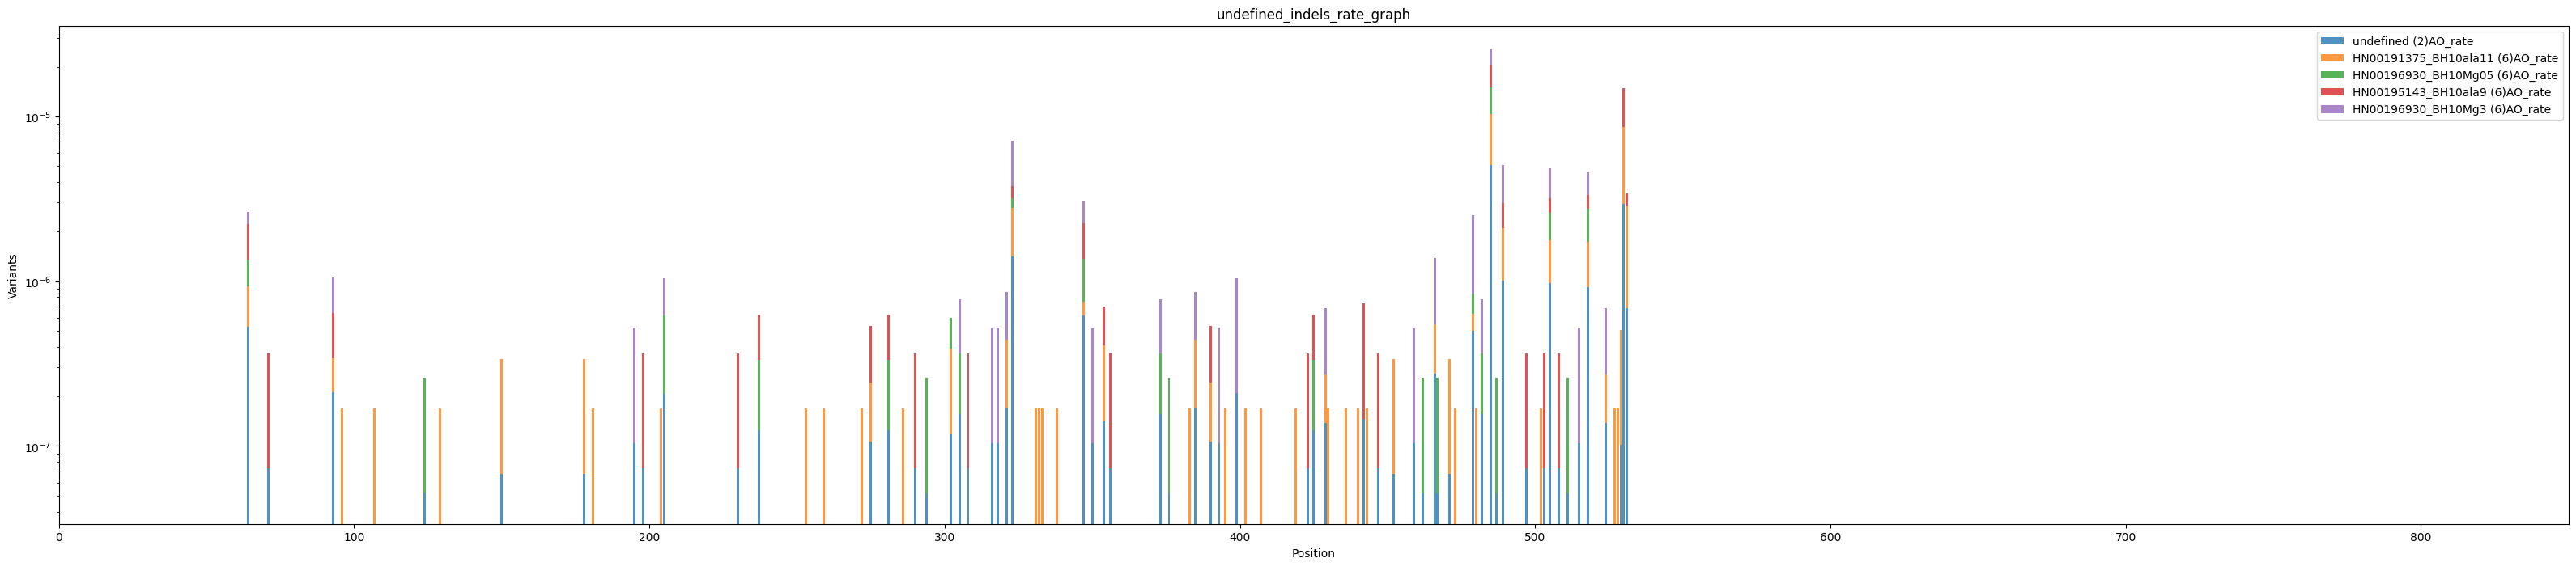

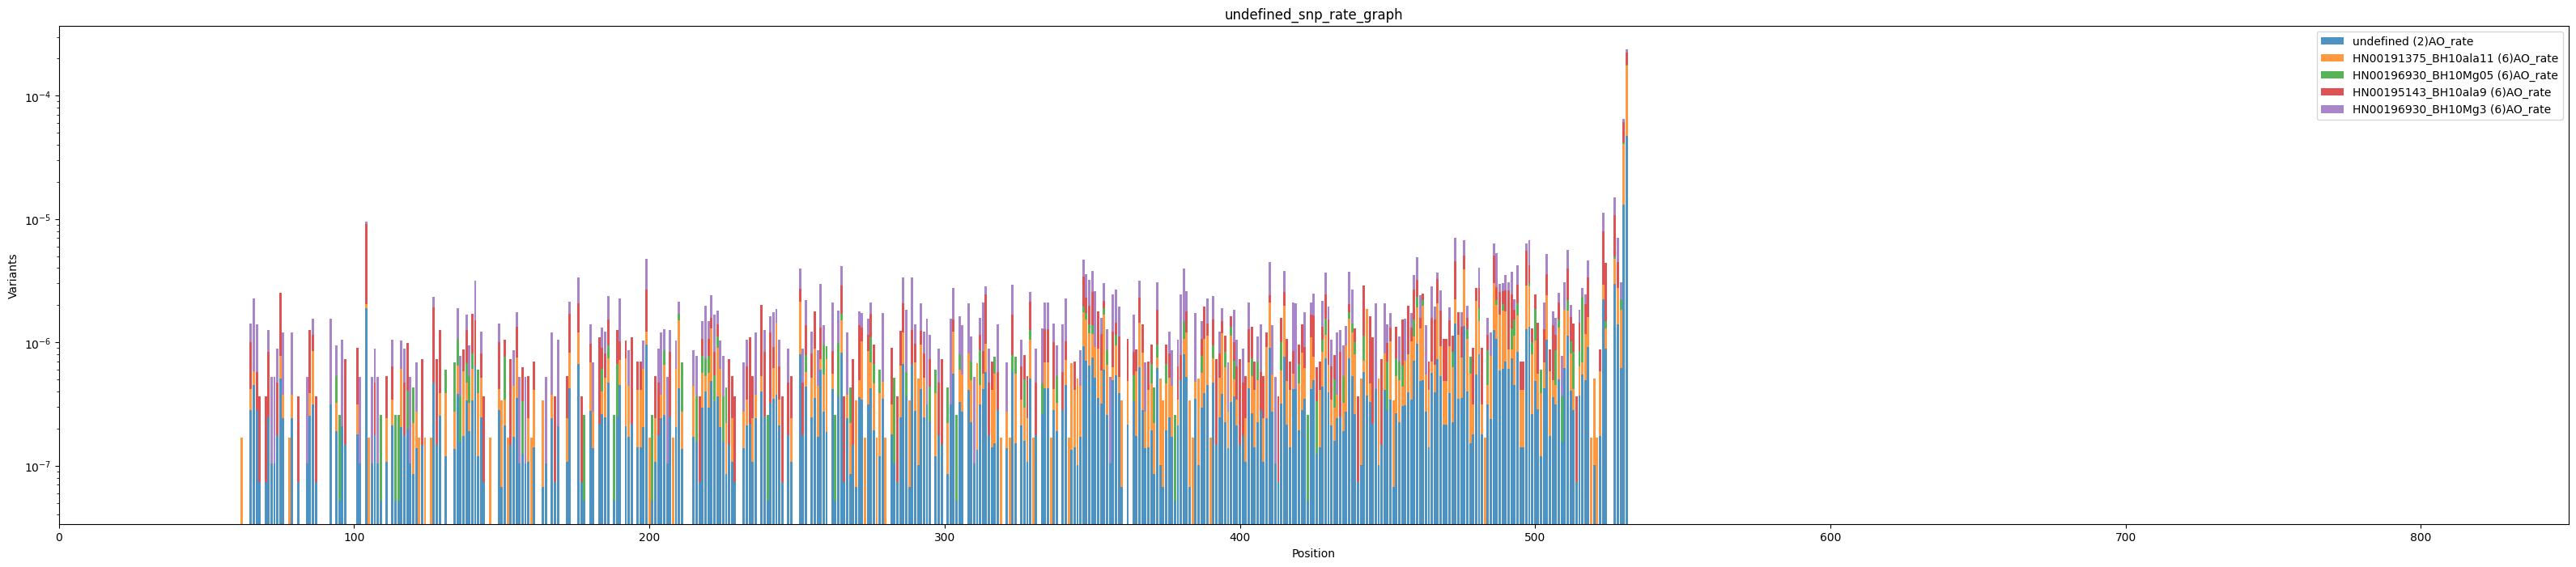

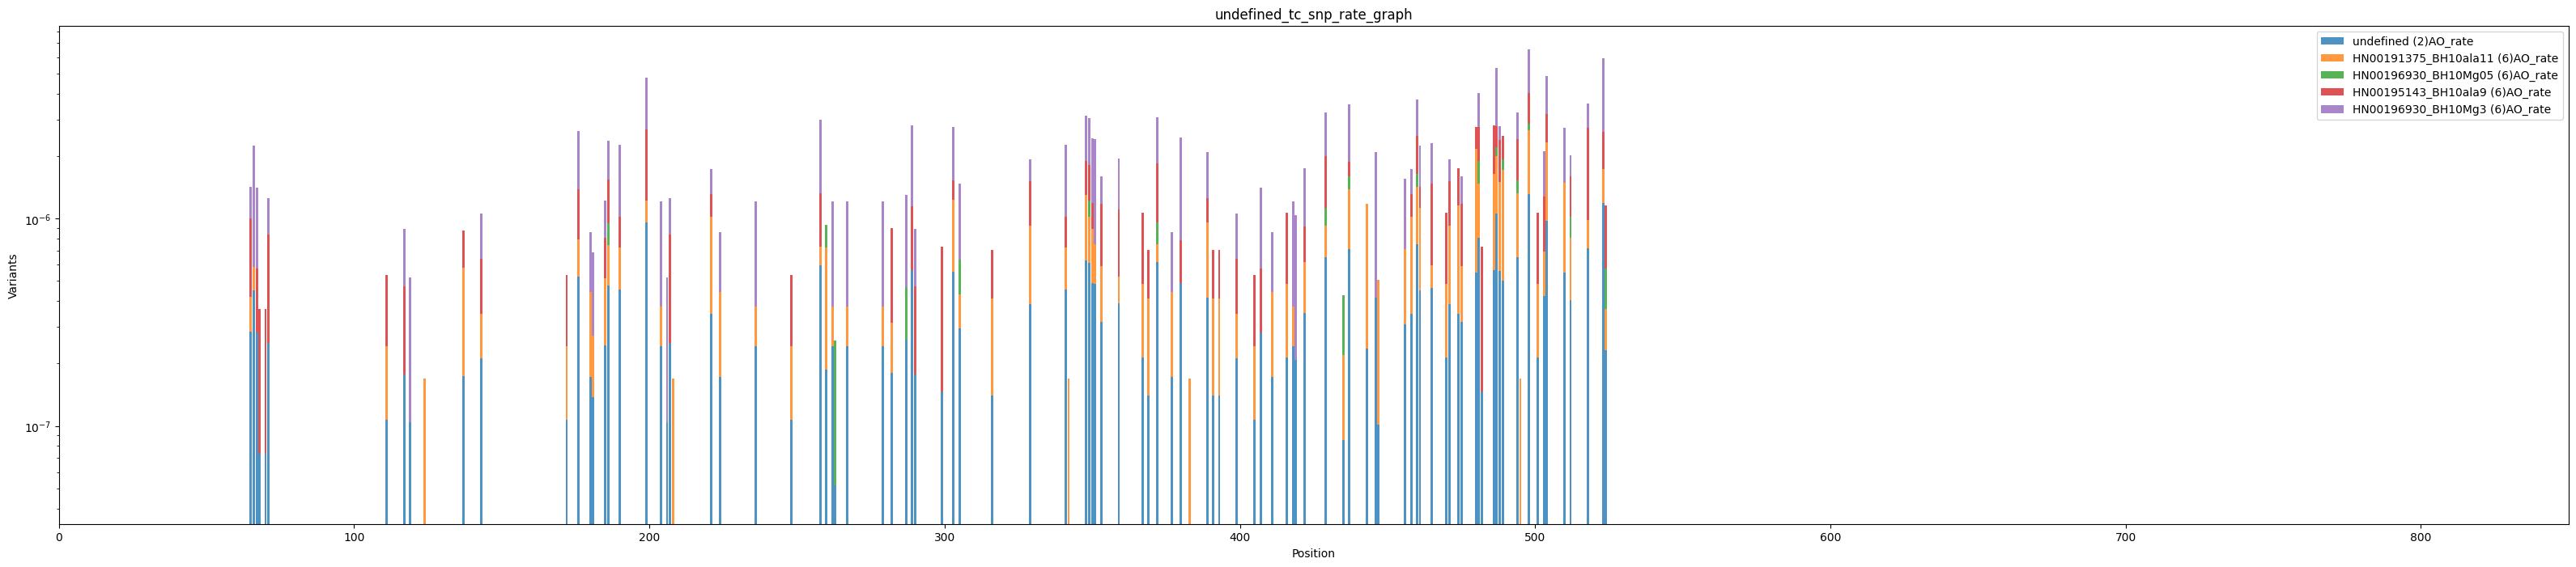

In [ ]:
#@markdown # Main program

!pip install xlsxwriter
import pandas as pd
import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

def create_dict_snp_types(merged_df, ao_columns):
  dict_snp_types={}
  def count_snp_types(row):
    snp_type = row["REF"] + row["ALT"]
    try:
      dict_snp_types[snp_type] += row[ao_columns].sum()
    except:
      dict_snp_types[snp_type] = row[ao_columns].sum()
  merged_df[merged_df["TYPE"]=="snp"].apply(count_snp_types, axis=1)
  return dict_snp_types

def create_df_snp_types(dict_snp_types):
  # Creates a dataframe using the dictionary of snp_types obtained with create_dict_snp_types function
  # In the left part of the table we show the nucleotides in the reference sequence and in the upper part of the table the nucleotides for which they are substituted.
  bases = ['G', 'A', 'T', 'C']
  table = {}
  for base in bases:
      table[base] = {}
      for otra_base in bases:
          table[base][otra_base] = None
  for key, value in dict_snp_types.items():
      base1 = key[1]
      base2 = key[0]
      table[base1][base2] = str(value)
  df_snp_types = pd.DataFrame(table)
  return df_snp_types

def create_cumulative_graph(dataframe, AO_columns, output_prefix, graph_name, graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max):
  #Creates a CUMULATIVE BAR GRAPH
  AO_values = dataframe[AO_columns]
  fig, ax = plt.subplots(figsize=(40, 8))
  bottom = np.zeros(len(dataframe['POS']))  # Variable to store the cumulative height of the previous bars.
  for col in AO_columns:
      ax.bar(dataframe['POS'], AO_values[col], alpha=0.8, bottom=bottom, label=col)
      bottom += AO_values[col]
  ax.set_xlabel('Position')
  ax.set_ylabel('Variants')
  ax.set_title(output_prefix + "_" + graph_name)
  ax.legend()
  if graphs_log_scale == True:
    plt.yscale('log')
  if graphs_detailed == True:
    positions = dataframe['POS'].unique()
    plt.xticks(positions, rotation=90)
  if graphs_fixed_range == True:
    plt.xlim(graphs_x_min, graphs_x_max)
  cumulative_graph = output_prefix + "_" + graph_name + "_graph.png"
  plt.savefig(cumulative_graph)
  return cumulative_graph

def process_merged_df(merged_df, output_prefix, graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max):
  #Stablish which columns contain AO and AO_rate info
  ao_columns = [col for col in merged_df.columns if col.endswith("AO")]
  ao_rate_columns = [col for col in merged_df.columns if col.endswith("AO_rate")]

  #Extract data
  df_with_shared_variants = merged_df.dropna().reset_index()
  total_variants_shared = merged_df.dropna()[ao_columns].sum().sum()
  total_unique_variants_shared = len(merged_df.dropna())
  df_with_shared_positions = merged_df.dropna().groupby('POS').sum(numeric_only=True).reset_index()
  total_positions_shared = len(merged_df.dropna().groupby('POS')[ao_columns].sum())

  merged_df.fillna(0, inplace=True) #we remove NaN values from the dataframe and replace them with zeros
  grouped_merged_df = merged_df.groupby('POS').sum(numeric_only=True).reset_index()
  total_variants = merged_df[ao_columns].sum().sum(numeric_only=True)
  total_unique_variants = len(merged_df)
  indels_df = merged_df[(merged_df["TYPE"] == "ins") | (merged_df["TYPE"] == "del")]
  grouped_indels_df = indels_df.groupby('POS').sum(numeric_only=True).reset_index()
  ins_df = merged_df[(merged_df["TYPE"] == "ins")]
  grouped_ins_df = ins_df.groupby('POS').sum(numeric_only=True).reset_index()
  del_df = merged_df[(merged_df["TYPE"] == "del")]
  grouped_del_df = del_df.groupby('POS').sum(numeric_only=True).reset_index()
  snp_df = merged_df[(merged_df["TYPE"] == "snp")]
  grouped_snp_df = snp_df.groupby('POS').sum(numeric_only=True).reset_index()
  df_TC_snp = merged_df[(merged_df['REF'] == 'T') & (merged_df['ALT'] == 'C')] #df with SNPs of the type T-->C

  dict_snp_types = create_dict_snp_types(merged_df, ao_columns)
  if all(math.isnan(value) for value in dict_snp_types.values()): #if all values dict_snp_types are "nan", we assign the value 0 to each substitution type
    dict_snp_types = {'TC': 0, 'TG': 0, 'AC': 0, 'AG': 0, 'AT': 0, 'GA': 0, 'GC': 0, 'GT': 0, 'CT': 0, 'CA': 0, 'TA': 0, 'CG': 0}
  df_snp_types = create_df_snp_types(dict_snp_types)

  basic_data_dict = {
    'Total variants': [total_variants],
    'Total unique variants': [total_unique_variants],
    'Total Variants shared': [total_variants_shared],
    'Total unique variants shared': [total_unique_variants_shared],
    'Total positions shared': [total_positions_shared]
  }
  df_basic_data = pd.DataFrame(basic_data_dict)

  # Create excel file with the extracted data
  global excel_file
  excel_file = output_prefix + '.xlsx'
  with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
      merged_df.to_excel(writer, sheet_name='Merged dataframes', index=False)
      grouped_merged_df.to_excel(writer, sheet_name='Variants per position', index=False)
      df_with_shared_positions.to_excel(writer, sheet_name='Shared positions', index=True)
      df_with_shared_variants.to_excel(writer, sheet_name='Shared variants', index=True)
      indels_df.to_excel(writer, sheet_name='Indels', index=False)
      ins_df.to_excel(writer, sheet_name='Insertions', index=False)
      del_df.to_excel(writer, sheet_name='Deletions', index=False)
      df_snp_types.to_excel(writer, sheet_name='SNP types', index=True)
      df_TC_snp.to_excel(writer, sheet_name='TC_snp', index=False)
      df_basic_data.to_excel(writer, sheet_name='Basic data', index=False)

  # Save dataframe with the sum of AO and the mean of AO_rate from all the samples as a csv file
  global csv_file
  double_merged_df = merged_df.copy()
  double_merged_df["AO"] = merged_df[ao_columns].sum(axis=1)
  double_merged_df["AO_rate"] = merged_df[ao_rate_columns].mean(axis=1)
  double_merged_df.drop(columns=ao_columns, inplace=True)
  double_merged_df.drop(columns=ao_rate_columns, inplace=True)
  csv_file = output_prefix + ".csv"
  double_merged_df.to_csv(csv_file, index=False)

  #Create heatmap image of the SNP types (shown as percentages)
  plt.clf()
  total_sum = sum(dict_snp_types.values())
  if total_sum != 0:
    dict_snp_types_percentage = {key: (value / total_sum) * 100 for key, value in dict_snp_types.items()}
  else:
    dict_snp_types_percentage = dict_snp_types
  df_table = create_df_snp_types(dict_snp_types_percentage)
  plt.figure(figsize=(6, 4))
  sns.heatmap(df_table.astype(float), cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': '%'})
  plt.gca().xaxis.set_label_position('top')
  plt.xlabel('Nucleotide substitutions')
  plt.ylabel('Reference nucleotides')
  plt.suptitle(output_prefix)
  plt.subplots_adjust(top=0.80)
  plt.gca().tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False) #Adjust position of ticks and x-axis labels
  plt.text(0.5, -0.1, f"Total number of substitutions: {total_sum}", transform=plt.gca().transAxes, ha='center') #Add total number of substitutions as text in the image
  global name_heatmap_snp_types
  name_heatmap_snp_types = output_prefix + 'heatmap_snp_types.png'
  plt.savefig(name_heatmap_snp_types)
  plt.close()

  #Create cumulative graphs
  global cumulative_graph_ao
  cumulative_graph_ao = create_cumulative_graph(grouped_merged_df, ao_columns, output_prefix, "total_ao", graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max)
  global cumulative_graph_ao_rate
  cumulative_graph_ao_rate = create_cumulative_graph(grouped_merged_df, ao_rate_columns, output_prefix, "total_ao_rate", graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max)
  global indels_graph
  indels_graph = create_cumulative_graph(grouped_indels_df, ao_rate_columns, output_prefix, "indels_rate_graph", graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max)
  global snp_graph
  snp_graph = create_cumulative_graph(grouped_snp_df, ao_rate_columns, output_prefix, "snp_rate_graph", graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max)
  global tc_snp_graph
  tc_snp_graph = create_cumulative_graph(df_TC_snp, ao_rate_columns, output_prefix, "tc_snp_rate_graph", graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max)

def csvs_to_df(csv_files):
  merged_df = pd.DataFrame(columns=['POS', 'REF', 'ALT', 'CIGAR', 'TYPE'])
  for file in csv_files:
    df = pd.read_csv(file)
    sample_name = file.split(".")[0]
    df = df.rename(columns={'AO': sample_name + '_AO', 'AO_rate': sample_name + 'AO_rate'}) #AO and AO_rate columns are renamed to identify samples
    merged_df = pd.merge(merged_df, df, on=['POS', 'REF', 'ALT', 'CIGAR', 'TYPE'], how='outer').sort_values('POS')
  return merged_df


## Main program
##-------------

def main():
  print("\tStep 1 => Creating merged dataframe")
  merged_df = csvs_to_df(csv_files) #Create merged_df with all merged df from csv files
  print("\tStep 1 done\n")

  print("\tStep 2 => Extracting data and creating graphs and tables")
  process_merged_df(merged_df, output_prefix, graphs_x_axis_size, graphs_y_axis_size, graphs_log_scale, graphs_detailed, graphs_fixed_range, graphs_x_min, graphs_x_max) #Extract data from the merged_df and create graphs and tables
  print("\tStep 2 done\n")

  print("\tJOB DONE!")

if __name__ == "__main__":
    main()

In [ ]:
#@markdown # Download files
files.download(excel_file)
files.download(csv_file)
files.download(name_heatmap_snp_types)
files.download(cumulative_graph_ao)
files.download(cumulative_graph_ao_rate)
files.download(indels_graph)
files.download(snp_graph)
files.download(tc_snp_graph)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>